In [ ]:
%pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 13.3 MB/s 


In [ ]:
import visualkeras as vk 

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/IA2022

/content/gdrive/MyDrive/IA2022


In [ ]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D,UpSampling2D
from keras.models import Model, Sequential

def generador_de_imagenes():

    generador = Sequential()

    generador.add(Dense(256*4*4, input_shape = (100,)))
    generador.add(LeakyReLU())
    generador.add(Reshape((4,4,256)))
#-----------------------------------------------------------------------------------------
    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    generador.add(LeakyReLU(alpha=0.2))

#-----------------------------------------------------------------------------------------
    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    generador.add(LeakyReLU(alpha=0.2))

#-----------------------------------------------------------------------------------------

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    generador.add(LeakyReLU(alpha=0.2))
    generador.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    return(generador)

modelo_generador = 0
modelo_generador = generador_de_imagenes()

modelo_generador.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 8, 8, 128)        295040    
 Transpose)                                                      
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 8, 8, 128)        147584    
 Transpose)                                           

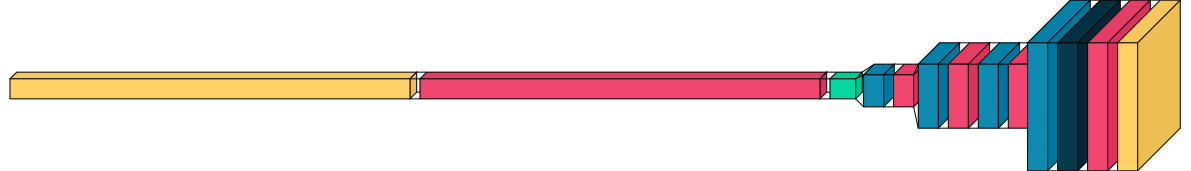

In [ ]:
vk.layered_view(modelo_generador)

In [ ]:
from keras.layers import Conv2D, Flatten,Dropout
from keras.optimizers import Adam

def discriminador_de_imagenes():

    discriminador = Sequential()


    discriminador.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (32,32,3)))
    discriminador.add(LeakyReLU(alpha=0.2))
   

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
   

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
  

    discriminador.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))


    discriminador.add(Flatten())
    discriminador.add(Dropout(0.4))
    discriminador.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0,0002,beta_1= 0,5)
    discriminador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminador)
modelo_discriminador =0
modelo_discriminador = discriminador_de_imagenes()
modelo_discriminador.summary()

SyntaxError: ignored

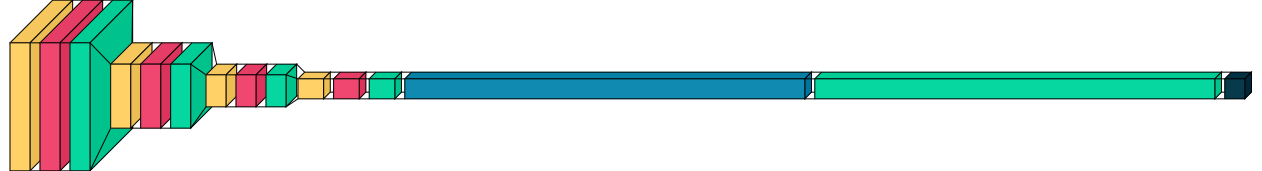

In [ ]:
vk.layered_view(modelo_discriminador)

Found 4597 files belonging to 1 classes.
(4597, 32, 32, 3)
1/1 [==============================] - 0s 19ms/step


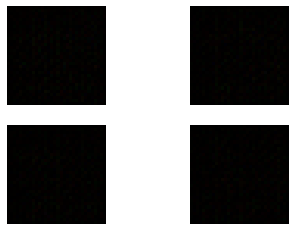

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
#import visualkeras
import random

def cargar_datos_reales(dataset, n_muestras):
  ix = np.random.randint(0, dataset.shape[0], n_muestras)
  X = dataset[ix]
  y = np.ones((n_muestras, 1))
  return X,y

def cargar_datos_fake(n_muestras):
  X = np.random.rand(32 * 32 * 3 * n_muestras)
  X = -1 + X * 2
  X = X.reshape((n_muestras, 32,32,3))
  y = np.ones((n_muestras, 1))
  return X,y

# Definir datos de entrada
def generar_datos_entrada(n_muestras):
  X = np.random.randn(100 * n_muestras)
  X = X.reshape(n_muestras, 100)
  return X

def crear_datos_fake(modelo_generador, n_muestras):
  input = generar_datos_entrada(n_muestras)
  X = modelo_generador.predict(input)
  y = np.zeros((n_muestras, 1))
  return X,y

def cargar_imagenes():
  train_ds = keras.utils.image_dataset_from_directory(
                directory='caras/',
                labels=None,
                batch_size=None,
                image_size=(32, 32))
  Y= np.stack(list(train_ds))
  Y=Y.astype('float32')
  Y=(Y - 127.5) / 127.5

  return Y
print(cargar_imagenes().shape)



numero_muestras = 4
X,_ = crear_datos_fake(modelo_generador, numero_muestras)

# Visualizamos resultados
for i in range(numero_muestras):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])




In [ ]:
%ls

In [ ]:
def entrenar_discriminador(modelo, dataset, n_iteraciones=10, batch =20):
  medio_batch = int(batch/2)

  for i in range(n_iteraciones):
    
     X_fake, y_fake = cargar_datos_fake(medio_batch)
     _, acc_fake = modelo.train_on_batch(X_fake, y_fake)
    
     X_real, y_real = cargar_datos_reales(dataset,medio_batch)
     _, acc_real = modelo.train_on_batch(X_real, y_real)

    

     print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))

In [ ]:
dataset = cargar_imagenes()
#entrenar_discriminador(modelo_discriminador, dataset)

Found 4597 files belonging to 1 classes.


In [ ]:
def crear_gan(discriminador, generador):
    discriminador.trainable=False
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminador)

    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan
gan=0
gan = crear_gan(modelo_discriminador,modelo_generador)
gan.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 32, 32, 3)         1302531   
                                                                 
 sequential_10 (Sequential)  (None, 1)                 522497    
                                                                 
Total params: 1,825,028
Trainable params: 1,302,531
Non-trainable params: 522,497
_________________________________________________________________


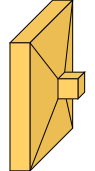

In [ ]:
vk.layered_view(gan)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime 

def mostrar_imagenes_generadas(datos_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  # Hacemos que los datos vayan de 0 a 1
  datos_fake = (datos_fake + 1) / 2.0

  for i in range(10):
    plt.imshow(datos_fake[i])
    plt.axis('off')
    nombre =str(epoch) + '_imagen_generada_' + str(i) + '.png'
    plt.savefig(nombre, bbox_inches='tight')
    plt.close()

def guardar_imagenes_generadas(datos_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  # Hacemos que los datos vayan de 0 a 1
  datos_fake = (datos_fake + 1) / 2.0

  for i in range(5*5):
    plt.subplot(5,5,i+1)   
    plt.axis('off')
    plt.imshow(datos_fake[i])
  nombre = str(epoch) + '_imagen_generada.png'
  plt.savefig(nombre, bbox_inches='tight')
  plt.close()


def plot_history(d_loss_r_hist,d_acc_r_hist, d_loss_f_hist, d_acc_f_hist, g_loss_hist,g_acc_hist,epoch):

	now = datetime.now()
	now = now.strftime("%Y%m%d_%H%M%S")
	plt.subplot(3, 1, 1)
	plt.plot(d_loss_r_hist, label='d-loss-real')
	plt.plot(d_acc_r_hist, label='d-acc-real')
	plt.legend()
	# plot discriminator accuracy
	plt.subplot(3, 1, 2)
	plt.plot(d_loss_f_hist, label='d-loss-fake')
	plt.plot(d_acc_f_hist, label='d-acc-fake')
	plt.legend()
	# save plot to file
	plt.subplot(3, 1, 3)
	plt.plot(g_loss_hist, label='g-loss')
	plt.plot(g_acc_hist, label='g-acc')
	plt.legend()
	nombre =str(epoch)+'_'+now+'_'+'plot_line_plot_loss.png'
	plt.savefig(nombre)
	plt.close()

In [ ]:
%ls

In [ ]:
def evaluar_y_guardar(modelo_generador, epoch, medio_dataset):

  # Guardamos el modelo
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  nombre =str(epoch) + '_' + str(now)+"_modelo_generador_" + '.h5'
  modelo_generador.save(nombre)

  # Generamos nuevos datos
  X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)
  X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

  # Evaluamos el modelo
  _, acc_real = modelo_discriminador.evaluate(X_real, Y_real)
  _, acc_fake = modelo_discriminador.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [ ]:
from keras.models import load_model

#modelo_generador = load_model('9_20221129_222812_modelo_generador_.h5')



In [ ]:
print(dataset.shape[0])

4597


In [ ]:
def entrenamiento(datos, modelo_generador, modelo_discriminador, epochs, t_batch, inicio = 0):
 # dimension_batch = int(datos.shape[0]/n_batch)
  cantidad_batch = int(dataset.shape[0]/t_batch)
  epocas=0
  
  # prepare lists for storing stats each iteration  
  d_loss_r_hist,d_acc_r_hist,d_loss_f_hist,d_acc_f_hist,g_loss_hist,g_acc_hist=list(),list(),list(),list(),list(),list()
  sum_d_loss_r,sum_d_acc_r,sum_d_loss_f,sum_d_acc_f,sum_g_loss, sum_g_acc=0,0,0,0,0,0
  # Iteramos para todos los epochs
  for epoch in range(inicio, inicio + epochs):
    print("epoca numero: ",epocas)
    epocas=epocas+1
    # Iteramos para todos los batches
    for batch in range(cantidad_batch):
      sum_d_loss_r=0
      sum_d_acc_r=0
      sum_d_loss_f=0
      sum_d_acc_f=0
      sum_g_loss=0
      sum_g_acc=0 
      # Cargamos datos reales   
      X_fake, Y_fake =  crear_datos_fake(modelo_generador, t_batch) 
      _, acc_fake = modelo_discriminador.evaluate(X_fake, Y_fake)
      X_real,Y_real = cargar_datos_reales(dataset, t_batch)      
      if acc_fake< 0.8:      
        # Enrenamos discriminador con datos reales
        d_loss_r, d_acc_r = modelo_discriminador.train_on_batch(X_real, Y_real)  
        # Enrenamos discriminador con datos falsos    
        d_loss_f, d_acc_f = modelo_discriminador.train_on_batch(X_fake, Y_fake)
      else:
        d_loss_r, d_acc_r = modelo_discriminador.evaluate(X_real, Y_real)
        d_loss_f, d_acc_f = modelo_discriminador.evaluate(X_fake, Y_fake)
        
      # Generamos datos de entadas de la GAN
      X_gan = generar_datos_entrada(t_batch)
      Y_gan = np.ones((t_batch, 1))
      # Entrenamos la GAN con datos falsos
      #g_loss,g_acc = gan.train_on_batch(X_gan, Y_gan)
      g_loss = gan.train_on_batch(X_gan, Y_gan)

      g_acc=0
      sum_d_loss_r=sum_d_loss_r+d_loss_r
      sum_d_acc_r=sum_d_acc_r+d_acc_r 
      sum_d_loss_f=sum_d_loss_f+d_loss_f
      sum_d_acc_f=sum_d_acc_f+d_acc_f
      sum_g_loss=sum_g_loss+g_loss
      sum_g_acc=sum_g_acc+g_acc
    # record history
    d_loss_r_hist.append(float(sum_d_loss_r/cantidad_batch))
    d_acc_r_hist.append(float(sum_d_acc_r/cantidad_batch))
    d_loss_f_hist.append(float(sum_d_loss_f/cantidad_batch))
    d_acc_f_hist.append(float( sum_d_acc_f/cantidad_batch))
    g_loss_hist.append(float(sum_g_loss/cantidad_batch))
    g_acc_hist.append(float(sum_g_acc/cantidad_batch))


    plot_history(d_loss_r_hist, d_acc_r_hist, d_loss_f_hist, d_acc_f_hist, g_loss_hist,g_acc_hist,epoch)
    evaluar_y_guardar(modelo_generador,epoch = epoch, medio_dataset=cantidad_batch)
    X_fake,_=crear_datos_fake(modelo_generador,50)  
    guardar_imagenes_generadas(X_fake, epoch)
     


In [ ]:
entrenamiento(dataset, modelo_generador, modelo_discriminador, epochs=300, t_batch=50, inicio = 0)

epoca numero:  0
2/2 [==============================] - 0s 8ms/step - loss: 0.4991 - accuracy: 0.8600


3/3 [==============================] - 0s 6ms/step - loss: 0.7597 - accuracy: 0.4176
Acc Real:100.0% Acc Fake:41.75824224948883%
2/2 [==============================] - 0s 6ms/step
epoca numero:  1
2/2 [==============================] - 0s 9ms/step - loss: 1.7504e-12 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 1.8550e-12 - accuracy: 1.0000
Acc Real:95.60439586639404% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  2
2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:87.91208863258362% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  3
2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:87.91208863258362% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  4
2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:86.81318759918213% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  5
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:87.91208863258362% Acc Fake:100.0%
2/2 [==============================] - 0s 8ms/step
epoca numero:  6
2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:80.2197813987732% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  7
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:90.1098906993866% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  8
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:90.1098906993866% Acc Fake:100.0%
2/2 [==============================] - 0s 8ms/step
epoca numero:  9
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:86.81318759918213% Acc Fake:100.0%
2/2 [==============================] - 0s 8ms/step
epoca numero:  10
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:87.91208863258362% Acc Fake:100.0%
2/2 [==============================] - 0s 8ms/step
epoca numero:  11
2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:86.81318759918213% Acc Fake:100.0%
2/2 [==============================] - 0s 8ms/step
epoca numero:  12
2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:89.01098966598511% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  13
2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:89.01098966598511% Acc Fake:100.0%
2/2 [==============================] - 0s 9ms/step
epoca numero:  14
2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:91.20879173278809% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  15
2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:91.20879173278809% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  16
2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:92.30769276618958% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  17
2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:82.41758346557617% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  18
2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:91.20879173278809% Acc Fake:100.0%
2/2 [==============================] - 0s 9ms/step
epoca numero:  19
2/2 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:85.71428656578064% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  20
2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:93.40659379959106% Acc Fake:100.0%
2/2 [==============================] - 0s 12ms/step
epoca numero:  21
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:91.20879173278809% Acc Fake:100.0%
2/2 [==============================] - 0s 11ms/step
epoca numero:  22
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:86.81318759918213% Acc Fake:100.0%
2/2 [==============================] - 0s 13ms/step
epoca numero:  23
2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:90.1098906993866% Acc Fake:100.0%
2/2 [==============================] - 0s 12ms/step
epoca numero:  24
2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:87.91208863258362% Acc Fake:100.0%
2/2 [==============================] - 0s 9ms/step
epoca numero:  25
2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:90.1098906993866% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  26
2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:83.51648449897766% Acc Fake:100.0%
2/2 [==============================] - 0s 12ms/step
epoca numero:  27
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:87.91208863258362% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  28
2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:89.01098966598511% Acc Fake:100.0%
2/2 [==============================] - 0s 9ms/step
epoca numero:  29
2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:92.30769276618958% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  30
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:89.01098966598511% Acc Fake:100.0%
2/2 [==============================] - 0s 8ms/step
epoca numero:  31
2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:91.20879173278809% Acc Fake:100.0%
2/2 [==============================] - 0s 13ms/step
epoca numero:  32
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:87.91208863258362% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  33
2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:85.71428656578064% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  34
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:85.71428656578064% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  35
2/2 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:91.20879173278809% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  36
2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:85.71428656578064% Acc Fake:100.0%
2/2 [==============================] - 0s 14ms/step
epoca numero:  37
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:84.61538553237915% Acc Fake:100.0%
2/2 [==============================] - 0s 14ms/step
epoca numero:  38
2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:91.20879173278809% Acc Fake:100.0%
2/2 [==============================] - 0s 8ms/step
epoca numero:  39
2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:89.01098966598511% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  40
2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:85.71428656578064% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  41
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:93.40659379959106% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  42
2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:95.60439586639404% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  43
2/2 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:92.30769276618958% Acc Fake:100.0%
2/2 [==============================] - 0s 12ms/step
epoca numero:  44
2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:91.20879173278809% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  45
2/2 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:84.61538553237915% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  46
2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:89.01098966598511% Acc Fake:100.0%
2/2 [==============================] - 0s 11ms/step
epoca numero:  47
2/2 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:90.1098906993866% Acc Fake:100.0%
2/2 [==============================] - 0s 9ms/step
epoca numero:  48
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:93.40659379959106% Acc Fake:100.0%
2/2 [==============================] - 0s 15ms/step
epoca numero:  49
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:85.71428656578064% Acc Fake:100.0%
2/2 [==============================] - 0s 11ms/step
epoca numero:  50
2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:94.50549483299255% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  51
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:90.1098906993866% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  52
2/2 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:84.61538553237915% Acc Fake:100.0%
2/2 [==============================] - 0s 9ms/step
epoca numero:  53
2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:85.71428656578064% Acc Fake:100.0%
2/2 [==============================] - 0s 8ms/step
epoca numero:  54
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:91.20879173278809% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  55
2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:87.91208863258362% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  56
2/2 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:90.1098906993866% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  57
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:91.20879173278809% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  58
2/2 [==============================] - 0s 14ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:86.81318759918213% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  59
2/2 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:85.71428656578064% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  60
2/2 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:86.81318759918213% Acc Fake:100.0%
2/2 [==============================] - 0s 11ms/step
epoca numero:  61
2/2 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:86.81318759918213% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  62
2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:89.01098966598511% Acc Fake:100.0%
2/2 [==============================] - 0s 8ms/step
epoca numero:  63
2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:89.01098966598511% Acc Fake:100.0%
2/2 [==============================] - 0s 14ms/step
epoca numero:  64
2/2 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 11ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:91.20879173278809% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  65
2/2 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000


3/3 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Acc Real:89.01098966598511% Acc Fake:100.0%
2/2 [==============================] - 0s 9ms/step
epoca numero:  66
2/2 [==============================] - 0s 8ms/step - loss: 1.1261 - accuracy: 0.8400


3/3 [==============================] - 0s 13ms/step - loss: 1.0728 - accuracy: 0.8901
Acc Real:91.20879173278809% Acc Fake:89.01098966598511%
2/2 [==============================] - 0s 7ms/step
epoca numero:  67
2/2 [==============================] - 0s 10ms/step - loss: 0.0293 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0284 - accuracy: 1.0000
Acc Real:100.0% Acc Fake:100.0%
2/2 [==============================] - 0s 20ms/step
epoca numero:  68
2/2 [==============================] - 0s 16ms/step - loss: 0.0508 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0583 - accuracy: 1.0000
Acc Real:97.80219793319702% Acc Fake:100.0%
2/2 [==============================] - 0s 9ms/step
epoca numero:  69
2/2 [==============================] - 0s 13ms/step - loss: 0.2789 - accuracy: 0.9000


3/3 [==============================] - 0s 8ms/step - loss: 0.7640 - accuracy: 0.5604
Acc Real:95.60439586639404% Acc Fake:56.04395866394043%
2/2 [==============================] - 0s 13ms/step
epoca numero:  70
2/2 [==============================] - 0s 20ms/step - loss: 0.0015 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 1.0000
Acc Real:86.81318759918213% Acc Fake:100.0%
2/2 [==============================] - 0s 9ms/step
epoca numero:  71
2/2 [==============================] - 0s 15ms/step - loss: 0.0134 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0141 - accuracy: 1.0000
Acc Real:83.51648449897766% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  72
2/2 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0270 - accuracy: 1.0000
Acc Real:93.40659379959106% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  73
2/2 [==============================] - 0s 17ms/step - loss: 0.0351 - accuracy: 1.0000


3/3 [==============================] - 0s 11ms/step - loss: 0.0353 - accuracy: 1.0000
Acc Real:93.40659379959106% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  74
2/2 [==============================] - 0s 11ms/step - loss: 0.7066 - accuracy: 0.5400


3/3 [==============================] - 0s 10ms/step - loss: 6.5269e-04 - accuracy: 1.0000
Acc Real:81.31868243217468% Acc Fake:100.0%
2/2 [==============================] - 0s 12ms/step
epoca numero:  75
2/2 [==============================] - 0s 7ms/step - loss: 8.3649e-05 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 1.0485e-04 - accuracy: 1.0000
Acc Real:86.81318759918213% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  76
2/2 [==============================] - 0s 11ms/step - loss: 7.3503e-06 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0012 - accuracy: 1.0000
Acc Real:81.31868243217468% Acc Fake:100.0%
2/2 [==============================] - 0s 9ms/step
epoca numero:  77
2/2 [==============================] - 0s 17ms/step - loss: 1.7157e-07 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 1.7620e-07 - accuracy: 1.0000
Acc Real:87.91208863258362% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  78
2/2 [==============================] - 0s 8ms/step - loss: 1.0485e-19 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 1.3646e-19 - accuracy: 1.0000
Acc Real:49.450549483299255% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  79
2/2 [==============================] - 0s 7ms/step - loss: 1.1297e-13 - accuracy: 1.0000


3/3 [==============================] - 0s 11ms/step - loss: 1.2263e-13 - accuracy: 1.0000
Acc Real:60.43956279754639% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  80
2/2 [==============================] - 0s 8ms/step - loss: 0.0692 - accuracy: 1.0000


3/3 [==============================] - 0s 11ms/step - loss: 0.0700 - accuracy: 1.0000
Acc Real:60.43956279754639% Acc Fake:100.0%
2/2 [==============================] - 0s 8ms/step
epoca numero:  81
2/2 [==============================] - 0s 7ms/step - loss: 0.2017 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.1966 - accuracy: 1.0000
Acc Real:63.736265897750854% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  82
2/2 [==============================] - 0s 7ms/step - loss: 0.2920 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.2877 - accuracy: 1.0000
Acc Real:53.84615659713745% Acc Fake:100.0%
2/2 [==============================] - 0s 9ms/step
epoca numero:  83
2/2 [==============================] - 0s 7ms/step - loss: 0.3395 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.3426 - accuracy: 1.0000
Acc Real:58.24176073074341% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  84
2/2 [==============================] - 0s 12ms/step - loss: 0.3845 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.3764 - accuracy: 1.0000
Acc Real:59.3406617641449% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  85
2/2 [==============================] - 0s 11ms/step - loss: 0.4386 - accuracy: 1.0000


3/3 [==============================] - 0s 14ms/step - loss: 0.4342 - accuracy: 1.0000
Acc Real:59.3406617641449% Acc Fake:100.0%
2/2 [==============================] - 0s 13ms/step
epoca numero:  86
2/2 [==============================] - 0s 8ms/step - loss: 0.4571 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.4557 - accuracy: 1.0000
Acc Real:50.54945349693298% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  87
2/2 [==============================] - 0s 12ms/step - loss: 0.4813 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.4842 - accuracy: 1.0000
Acc Real:54.94505763053894% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  88
2/2 [==============================] - 0s 8ms/step - loss: 0.5530 - accuracy: 1.0000


3/3 [==============================] - 0s 11ms/step - loss: 0.5563 - accuracy: 1.0000
Acc Real:56.04395866394043% Acc Fake:100.0%
2/2 [==============================] - 0s 8ms/step
epoca numero:  89
2/2 [==============================] - 0s 8ms/step - loss: 0.5686 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.5699 - accuracy: 1.0000
Acc Real:54.94505763053894% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  90
2/2 [==============================] - 0s 6ms/step - loss: 0.6130 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.6157 - accuracy: 1.0000
Acc Real:56.04395866394043% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  91
2/2 [==============================] - 0s 8ms/step - loss: 0.6325 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.6278 - accuracy: 1.0000
Acc Real:47.25274741649628% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  92
2/2 [==============================] - 0s 9ms/step - loss: 0.6546 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.6519 - accuracy: 1.0000
Acc Real:52.74725556373596% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  93
2/2 [==============================] - 0s 9ms/step - loss: 0.6594 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.6621 - accuracy: 1.0000
Acc Real:65.93406796455383% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  94
2/2 [==============================] - 0s 8ms/step - loss: 0.6693 - accuracy: 0.9800


3/3 [==============================] - 0s 11ms/step - loss: 0.6730 - accuracy: 0.9890
Acc Real:57.14285969734192% Acc Fake:98.90109896659851%
2/2 [==============================] - 0s 7ms/step
epoca numero:  95
2/2 [==============================] - 0s 8ms/step - loss: 0.0031 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0031 - accuracy: 1.0000
Acc Real:69.2307710647583% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  96
2/2 [==============================] - 0s 8ms/step - loss: 0.0034 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0034 - accuracy: 1.0000
Acc Real:76.92307829856873% Acc Fake:100.0%
2/2 [==============================] - 0s 12ms/step
epoca numero:  97
2/2 [==============================] - 0s 6ms/step - loss: 0.0035 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0036 - accuracy: 1.0000
Acc Real:75.82417726516724% Acc Fake:100.0%
2/2 [==============================] - 0s 8ms/step
epoca numero:  98
2/2 [==============================] - 0s 15ms/step - loss: 0.0036 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0036 - accuracy: 1.0000
Acc Real:78.02197933197021% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  99
2/2 [==============================] - 0s 13ms/step - loss: 0.0036 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0036 - accuracy: 1.0000
Acc Real:79.1208803653717% Acc Fake:100.0%
2/2 [==============================] - 0s 10ms/step
epoca numero:  100
2/2 [==============================] - 0s 8ms/step - loss: 0.0036 - accuracy: 1.0000


3/3 [==============================] - 0s 9ms/step - loss: 0.0036 - accuracy: 1.0000
Acc Real:75.82417726516724% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  101
2/2 [==============================] - 0s 9ms/step - loss: 0.0037 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0037 - accuracy: 1.0000
Acc Real:72.52747416496277% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  102
2/2 [==============================] - 0s 8ms/step - loss: 0.0037 - accuracy: 1.0000


3/3 [==============================] - 0s 5ms/step - loss: 0.0037 - accuracy: 1.0000
Acc Real:79.1208803653717% Acc Fake:100.0%
2/2 [==============================] - 0s 13ms/step
epoca numero:  103
2/2 [==============================] - 0s 8ms/step - loss: 0.0037 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0037 - accuracy: 1.0000
Acc Real:74.72527623176575% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  104
2/2 [==============================] - 0s 6ms/step - loss: 0.0038 - accuracy: 1.0000


3/3 [==============================] - 0s 8ms/step - loss: 0.0038 - accuracy: 1.0000
Acc Real:70.32967209815979% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  105
2/2 [==============================] - 0s 9ms/step - loss: 0.0039 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0039 - accuracy: 1.0000
Acc Real:76.92307829856873% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  106
2/2 [==============================] - 0s 8ms/step - loss: 0.0040 - accuracy: 1.0000


3/3 [==============================] - 0s 12ms/step - loss: 0.0040 - accuracy: 1.0000
Acc Real:72.52747416496277% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  107
2/2 [==============================] - 0s 7ms/step - loss: 0.0040 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0040 - accuracy: 1.0000
Acc Real:70.32967209815979% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  108
2/2 [==============================] - 0s 8ms/step - loss: 0.0040 - accuracy: 1.0000


3/3 [==============================] - 0s 6ms/step - loss: 0.0040 - accuracy: 1.0000
Acc Real:73.62637519836426% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  109
2/2 [==============================] - 0s 9ms/step - loss: 0.0040 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0040 - accuracy: 1.0000
Acc Real:72.52747416496277% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  110
2/2 [==============================] - 0s 9ms/step - loss: 0.0040 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0040 - accuracy: 1.0000
Acc Real:78.02197933197021% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  111
2/2 [==============================] - 0s 10ms/step - loss: 0.0040 - accuracy: 1.0000


3/3 [==============================] - 0s 7ms/step - loss: 0.0040 - accuracy: 1.0000
Acc Real:72.52747416496277% Acc Fake:100.0%
2/2 [==============================] - 0s 7ms/step
epoca numero:  112
2/2 [==============================] - 0s 6ms/step - loss: 0.0041 - accuracy: 1.0000


3/3 [==============================] - 0s 10ms/step - loss: 0.0041 - accuracy: 1.0000
Acc Real:67.03296899795532% Acc Fake:100.0%
2/2 [==============================] - 0s 6ms/step
epoca numero:  113
2/2 [==============================] - 0s 7ms/step - loss: 0.0042 - accuracy: 1.0000


KeyboardInterrupt: ignored

2/2 [==============================] - 0s 6ms/step


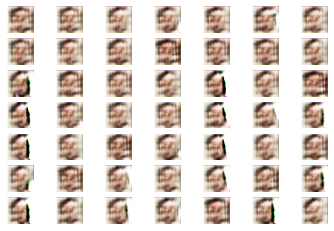

In [ ]:
X_fake, _ = crear_datos_fake(n_muestras=49, modelo_generador=modelo_generador)
X_fake = (X_fake+1)/2

for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X_fake[i])

1/1 [==============================] - 0s 15ms/step


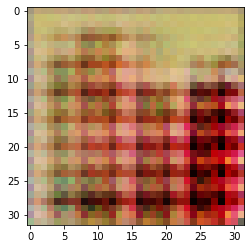

In [ ]:
X_fake, _ = crear_datos_fake(n_muestras=1, modelo_generador=modelo_generador)
X_fake = (X_fake+1)/2

plt.imshow(X_fake[0])